The code in this notebook is based on:

- [Huggingface notebook: Text Classification on GLUE](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [Answer.AI notebook: Finetune ModernBERT on GLUE](https://colab.research.google.com/github/AnswerDotAI/ModernBERT/blob/main/examples/finetune_modernbert_on_glue.ipynb)
- [Huggingface `transformers`: `run_glue.py` script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py)
- [BERT Fine-Tuning Tutorial with PyTorch by Chris McCormick](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

# Fine-Tuning BERT on GLUE - SST-2

From [Stanford Sentiment Analysis](https://nlp.stanford.edu/sentiment/index.html):

Semantic word spaces have been very useful but cannot express the meaning of longer phrases in a principled way. Further progress towards understanding compositionality in tasks such as sentiment detection requires richer supervised training and evaluation resources and more powerful models of composition. To remedy this, we introduce a Sentiment Treebank. It includes fine grained sentiment labels for 215,154 phrases in the parse trees of 11,855 sentences and presents new challenges for sentiment compositionality. 

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
from pathlib import Path

import numpy as np
from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)
np.random.seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "sst2"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA A40

==============NVSMI LOG==============

Timestamp                                 : Wed Jan 15 22:30:41 2025
Driver Version                            : 550.90.07
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:08:00.0
    FB Memory Usage
        Total                             : 46068 MiB
        Reserved                          : 665 MiB
        Used                              : 13365 MiB
        Free                              : 32039 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 4 MiB
        Free                              : 65532 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## 1. Dataset

In [5]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [6]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [7]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence,label,idx
66730,with outtakes in which most of the characters ...,0,66730
29890,enigma is well-made,1,29890
45801,is ) so stoked to make an important film about...,0,45801
29352,the closest thing to the experience of space t...,1,29352
19858,lose their luster,0,19858
15364,reopens an interesting controversy and,1,15364
30026,"competent , unpretentious entertainment",1,30026
38039,an effective portrait of a life in stasis,1,38039
14261,transcendent performance,1,14261
11661,so vivid,1,11661


In [8]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([0, 1])
num_labels=2


The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [9]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence,label,idx
275,nicely serves as an examination of a society i...,-1,275
1759,"here , adrian lyne comes as close to profundit...",-1,1759
1545,the people in dogtown and z-boys are so funny ...,-1,1545
845,"the year 's happiest surprise , a movie that d...",-1,845
1232,"a compelling , moving film that respects its a...",-1,1232
1230,"after seeing swept away , i feel sorry for mad...",-1,1230
523,most of the action setups are incoherent .,-1,523
970,a 93-minute condensation of a 26-episode tv se...,-1,970
1045,city by the sea is the cinematic equivalent of...,-1,1045
373,a charming yet poignant tale of the irrevocabl...,-1,373


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [10]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.1)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 60614
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 6735
    })
})

In [11]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 60614
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 6735
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [12]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence,label,idx
5263,'s a testament to de niro and director michael...,1,61911
6302,found in its ability to spoof both black and w...,1,4192
196,oozing with attractive men,1,11731
1271,credible gender-provoking philosophy,1,19955
5208,that 's lived too long,0,27374
773,it 's difficult to feel anything much while wa...,0,51285
252,"a photographic marvel of sorts , and it",1,52092
387,a small gem of a movie that defies classificat...,1,32492
2569,nervous,0,2797
4393,immature and,0,24579


## 2. BERT-base

In [13]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [15]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 66
Max length in split='validation': 55


Max length in split='test': 61


In [16]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/60614 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [17]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
sentence,powerful acting clinic
label,1
idx,59179
input_ids,"[101, 3928, 3772, 9349, 102]"
token_type_ids,"[0, 0, 0, 0, 0]"
attention_mask,"[1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,101,3928,3772,9349,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,1996,4288,2492,1998,1996.0,3347.0,25990.0,6491.0,1997.0,1036.0,5636.0,26799.0,102.0
2,101,2428,4136,1996,6925,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,101,3928,3772,9349,102,0,0,0,0,0,0,0,0,0
1,101,1996,4288,2492,1998,1996,3347,25990,6491,1997,1036,5636,26799,102
2,101,2428,4136,1996,6925,102,0,0,0,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [20]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [21]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [22]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task sst2


In [23]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [24]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [28]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-sst2/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.211700,0.198069,0.927752
2,0.110600,0.225307,0.923165
3,0.074300,0.241516,0.931193
4,0.049000,0.335300,0.930046
5,0.031500,0.348292,0.935780


In [29]:
training_summary_bert_base

TrainOutput(global_step=9475, training_loss=0.09543131684879515, metrics={'train_runtime': 667.1471, 'train_samples_per_second': 454.278, 'train_steps_per_second': 14.202, 'total_flos': 6257309174126640.0, 'train_loss': 0.09543131684879515, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [30]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.34829193353652954,
 'eval_accuracy': 0.9357798165137615,
 'eval_runtime': 0.6332,
 'eval_samples_per_second': 1377.088,
 'eval_steps_per_second': 44.218,
 'epoch': 5.0}

In [31]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2117,3.068891,0.000016,1895,0.198069,0.927752,0.6141,1419.866,45.592,NaN,NaN,NaN,NaN,NaN
2,0.1106,13.659736,0.000012,3790,0.225307,0.923165,0.6115,1426.032,45.790,NaN,NaN,NaN,NaN,NaN
3,0.0743,18.055183,0.000008,5685,0.241516,0.931193,0.6121,1424.511,45.741,NaN,NaN,NaN,NaN,NaN
4,0.0490,0.050290,0.000004,7580,0.335300,0.930046,0.6146,1418.719,45.555,NaN,NaN,NaN,NaN,NaN
5,0.0315,0.671728,0.000000,9475,0.348292,0.935780,0.6107,1427.925,45.851,667.1471,454.278,14.202,6.257309e+15,0.095431


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-base-uncased)

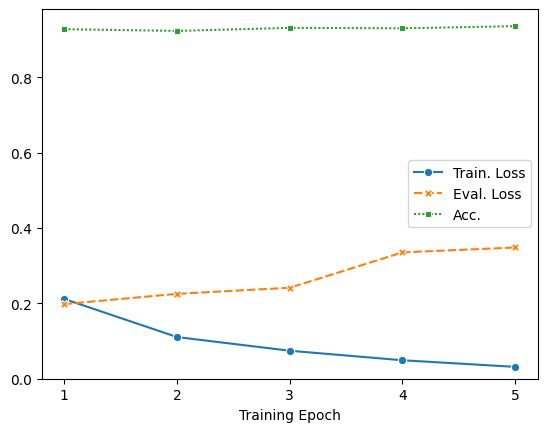

In [32]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 2.4 Evaluation

### Label frequency in test dataset

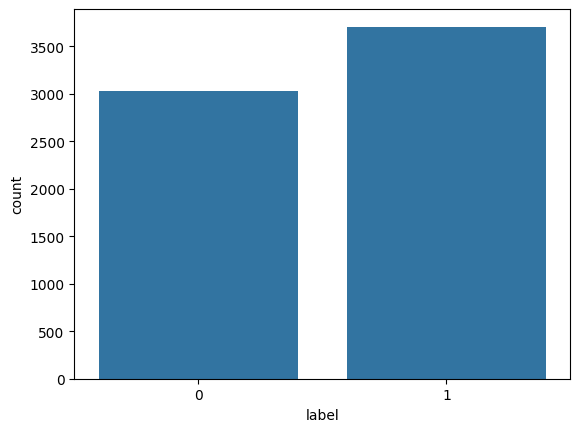

In [33]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in test dataset"))

The dataset classes seem to be somewhat unbalanced.

In [34]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-base-uncased)

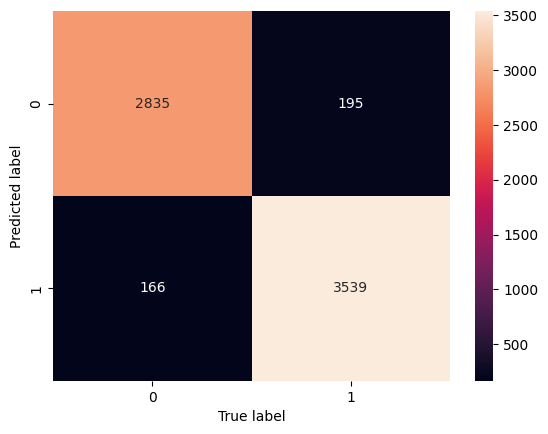

In [35]:
import sklearn.metrics

bert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [36]:
predictions.metrics

{'test_loss': 0.30372029542922974,
 'test_accuracy': 0.9463994060876021,
 'test_runtime': 4.0429,
 'test_samples_per_second': 1665.888,
 'test_steps_per_second': 52.19}

In [37]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [predictions.metrics["test_accuracy"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_accuracy"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-",0.935]
results["original BERT_LARGE"] = ["-", "-","-", 0.949]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,667.147100,-,-
eval_loss,0.348292,-,-
eval_accuracy,0.935780,-,-
test_accuracy,0.946399,0.935,0.949


## 3. BERT-Large

In [38]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/60614 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [40]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [41]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task sst2


In [42]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [43]:
BATCH_SIZE = 32  # BERT-large might need a smaller batch size

In [44]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

703

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-sst2/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.203200,0.175736,0.932339
2,0.108500,0.205536,0.938073
3,0.069800,0.261225,0.925459
4,0.042100,0.298365,0.925459
5,0.023000,0.358550,0.927752


In [47]:
training_summary_bert_large

TrainOutput(global_step=9475, training_loss=0.08932248641444385, metrics={'train_runtime': 2067.8854, 'train_samples_per_second': 146.56, 'train_steps_per_second': 4.582, 'total_flos': 2.216319896338027e+16, 'train_loss': 0.08932248641444385, 'epoch': 5.0})

In [48]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.20553630590438843,
 'eval_accuracy': 0.9380733944954128,
 'eval_runtime': 1.8669,
 'eval_samples_per_second': 467.082,
 'eval_steps_per_second': 14.998,
 'epoch': 5.0}

In [49]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2032,5.979378,0.000016,1895,0.175736,0.932339,1.8570,469.584,15.078,NaN,NaN,NaN,NaN,NaN
2,0.1085,1.698784,0.000012,3790,0.205536,0.938073,1.8539,470.352,15.103,NaN,NaN,NaN,NaN,NaN
3,0.0698,2.011059,0.000008,5685,0.261225,0.925459,1.8545,470.216,15.099,NaN,NaN,NaN,NaN,NaN
4,0.0421,0.032242,0.000004,7580,0.298365,0.925459,1.8588,469.126,15.064,NaN,NaN,NaN,NaN,NaN
5,0.0230,0.013187,0.000000,9475,0.358550,0.927752,1.8560,469.826,15.086,2067.8854,146.56,4.582,2.216320e+16,0.089322


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

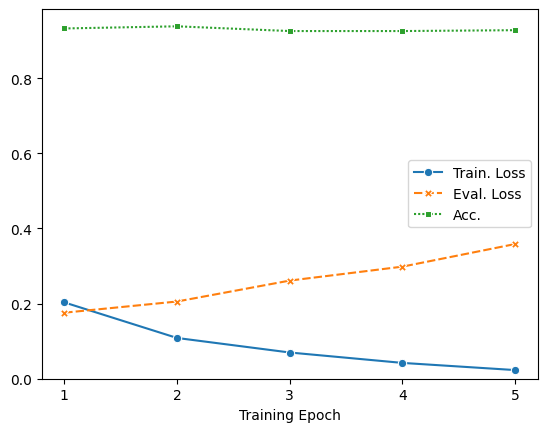

In [50]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [51]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-large-uncased)

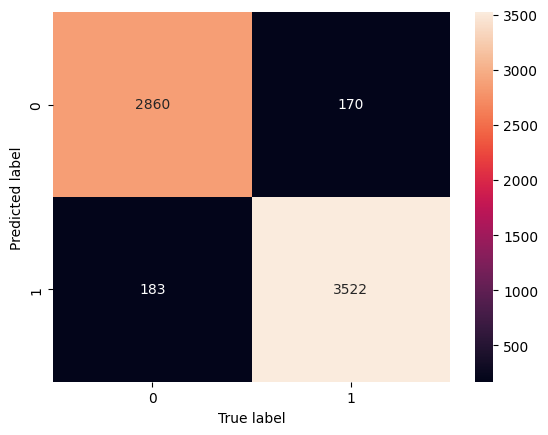

In [52]:
import sklearn.metrics

bert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [53]:
predictions.metrics

{'test_loss': 0.17079412937164307,
 'test_accuracy': 0.9475872308834447,
 'test_runtime': 12.0016,
 'test_samples_per_second': 561.175,
 'test_steps_per_second': 17.581}

In [54]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,667.147100,-,2067.885400,-
eval_loss,0.348292,-,0.205536,-
eval_accuracy,0.935780,-,0.938073,-
test_accuracy,0.946399,0.935,0.947587,0.949


## 4. ModernBERT-base

In [55]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [56]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/60614 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [57]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [58]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task sst2


In [59]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [60]:
BATCH_SIZE = 32

In [61]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

668

In [62]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-sst2/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.221600,0.152641,0.938073
2,0.107100,0.173752,0.933486
3,0.059900,0.196438,0.933486
4,0.030200,0.272869,0.933486
5,0.013700,0.339293,0.935780


In [64]:
training_summary_modernbert_base

TrainOutput(global_step=9475, training_loss=0.08650493229284764, metrics={'train_runtime': 673.2512, 'train_samples_per_second': 450.159, 'train_steps_per_second': 14.073, 'total_flos': 8406193904843448.0, 'train_loss': 0.08650493229284764, 'epoch': 5.0})

In [65]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.15248332917690277,
 'eval_accuracy': 0.9380733944954128,
 'eval_runtime': 0.5683,
 'eval_samples_per_second': 1534.32,
 'eval_steps_per_second': 49.267,
 'epoch': 5.0}

In [66]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2216,4.744256,0.000064,1895,0.152641,0.938073,0.5656,1541.663,49.503,NaN,NaN,NaN,NaN,NaN
2,0.1071,10.145433,0.000048,3790,0.173752,0.933486,0.5695,1531.277,49.169,NaN,NaN,NaN,NaN,NaN
3,0.0599,0.651478,0.000032,5685,0.196438,0.933486,0.5627,1549.717,49.762,NaN,NaN,NaN,NaN,NaN
4,0.0302,0.002272,0.000016,7580,0.272869,0.933486,0.5711,1526.865,49.028,NaN,NaN,NaN,NaN,NaN
5,0.0137,0.001023,0.000000,9475,0.339293,0.935780,0.5741,1518.774,48.768,673.2512,450.159,14.073,8.406194e+15,0.086505


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

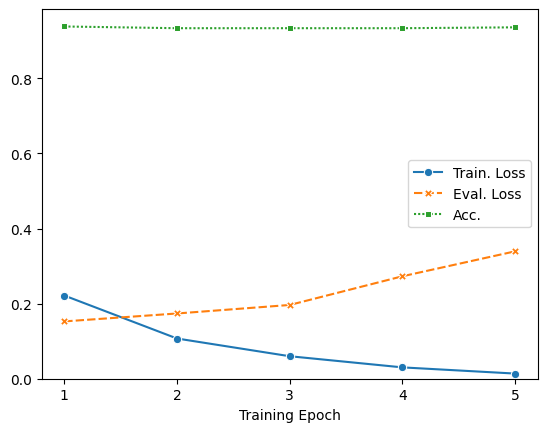

In [67]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [68]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-base)

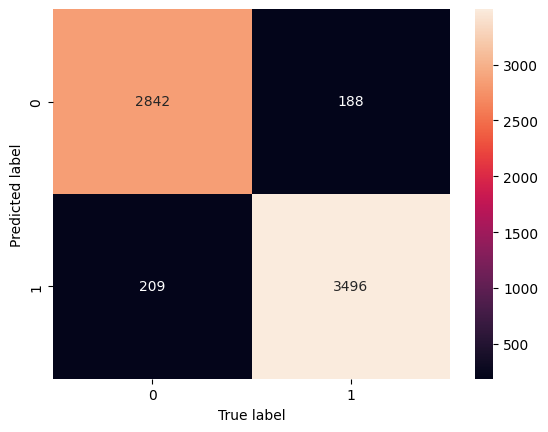

In [69]:
import sklearn.metrics

modernbert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [70]:
predictions.metrics

{'test_loss': 0.16985510289669037,
 'test_accuracy': 0.9410541945063103,
 'test_runtime': 4.2607,
 'test_samples_per_second': 1580.732,
 'test_steps_per_second': 49.523}

In [71]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,667.147100,-,673.251200,2067.885400,-
eval_loss,0.348292,-,0.152483,0.205536,-
eval_accuracy,0.935780,-,0.938073,0.938073,-
test_accuracy,0.946399,0.935,0.941054,0.947587,0.949


## 5. ModernBERT-Large

In [72]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [73]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/60614 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [74]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [75]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task sst2


In [76]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [77]:
BATCH_SIZE = 32

In [78]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [79]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-sst2/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.221800,0.180900,0.927752
2,0.115000,0.218356,0.920872
3,0.067800,0.208749,0.935780
4,0.037700,0.253663,0.930046
5,0.017800,0.356795,0.927752


In [81]:
training_summary_modernbert_large

TrainOutput(global_step=9475, training_loss=0.09202270346769871, metrics={'train_runtime': 1375.373, 'train_samples_per_second': 220.355, 'train_steps_per_second': 6.889, 'total_flos': 2.6088969036823224e+16, 'train_loss': 0.09202270346769871, 'epoch': 5.0})

In [82]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.20827068388462067,
 'eval_accuracy': 0.9357798165137615,
 'eval_runtime': 0.7829,
 'eval_samples_per_second': 1113.847,
 'eval_steps_per_second': 35.766,
 'epoch': 5.0}

In [83]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2218,4.329138,0.000064,1895,0.180900,0.927752,0.8888,981.108,31.503,NaN,NaN,NaN,NaN,NaN
2,0.1150,16.425215,0.000048,3790,0.218356,0.920872,0.8872,982.910,31.561,NaN,NaN,NaN,NaN,NaN
3,0.0678,4.381372,0.000032,5685,0.208749,0.935780,0.8968,972.391,31.224,NaN,NaN,NaN,NaN,NaN
4,0.0377,0.027913,0.000016,7580,0.253663,0.930046,0.8884,981.530,31.517,NaN,NaN,NaN,NaN,NaN
5,0.0178,0.004719,0.000000,9475,0.356795,0.927752,0.9076,960.724,30.849,1375.373,220.355,6.889,2.608897e+16,0.092023


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

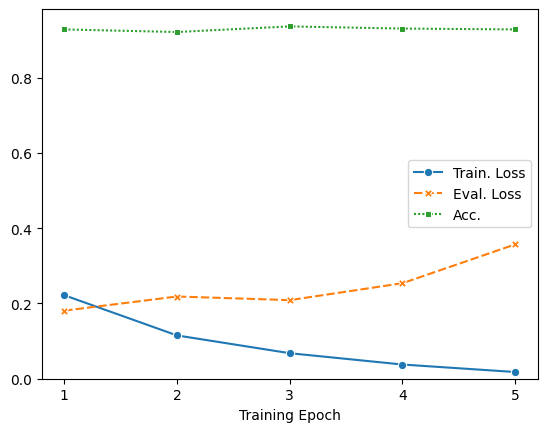

In [84]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [85]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-large)

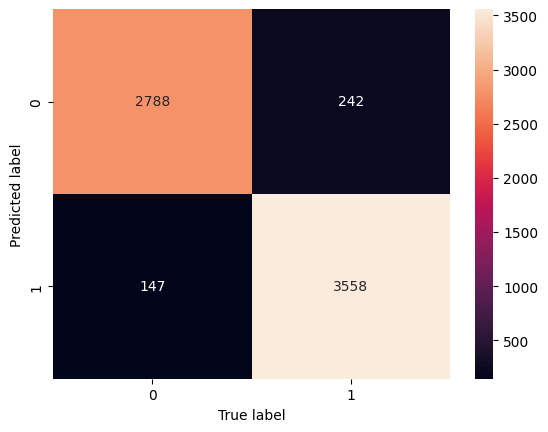

In [86]:
import sklearn.metrics

modernbert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [87]:
predictions.metrics

{'test_loss': 0.19294533133506775,
 'test_accuracy': 0.9422420193021529,
 'test_runtime': 5.4371,
 'test_samples_per_second': 1238.703,
 'test_steps_per_second': 38.807}

In [88]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,667.147100,-,673.251200,2067.885400,-,1375.373000
eval_loss,0.348292,-,0.152483,0.205536,-,0.208271
eval_accuracy,0.935780,-,0.938073,0.938073,-,0.935780
test_accuracy,0.946399,0.935,0.941054,0.947587,0.949,0.942242


# Summary

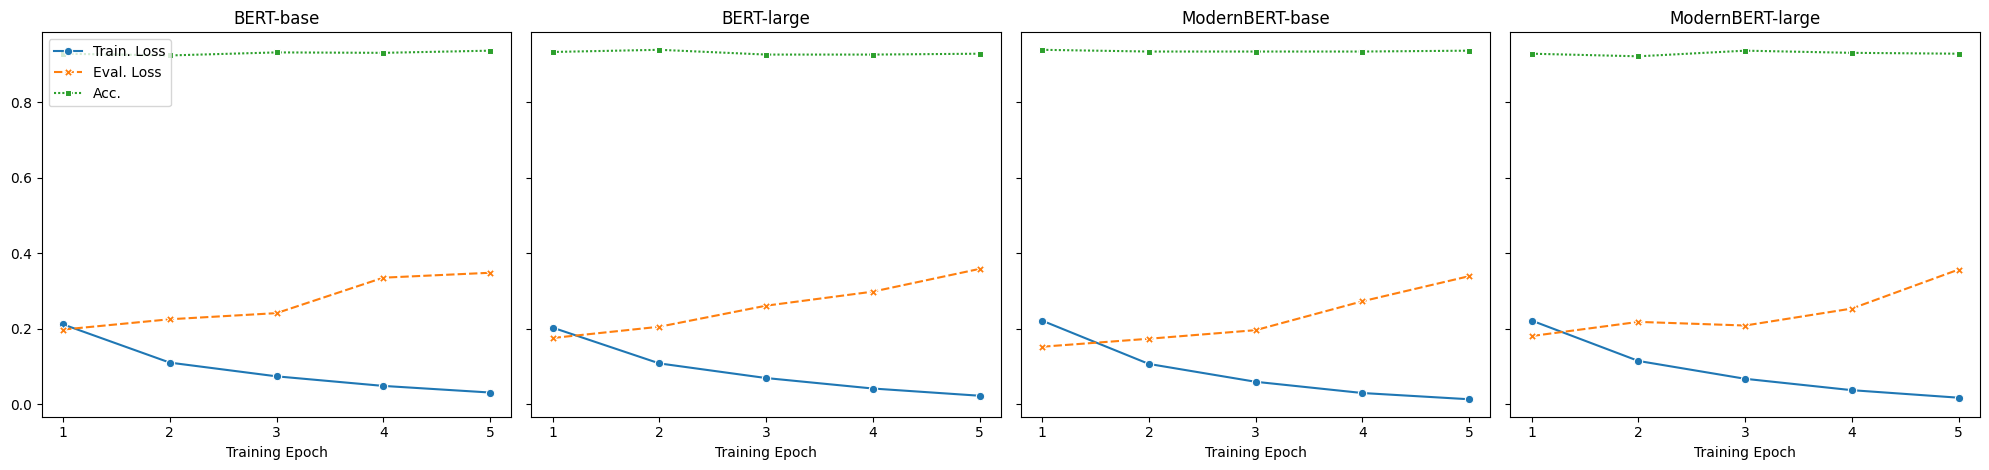

In [89]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

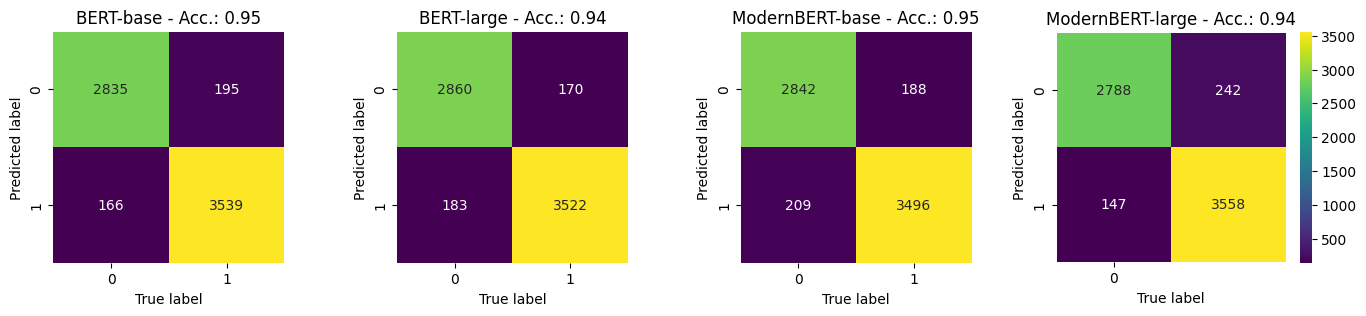

In [90]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
our_results = results.loc["test_accuracy"].drop("original BERT_BASE").drop("original BERT_LARGE")
titles = [title + " - " + f"Acc.: {acc:.2f}" for title, acc in zip(titles, our_results)]
cms = [bert_base_cm, bert_large_cm, modernbert_base_cm, modernbert_large_cm]

fig, axes = plt.subplots(ncols=len(cms),  figsize=(3,3))

def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title == titles[-1]
    plot = sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="viridis", cbar=include_cbar, ax=ax)
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)

for title, history, ax in zip(titles, cms, axes):
    draw_confusion_matrix_plot(title, history, ax)

fig.set_figwidth(17)

In [91]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,667.147100,-,673.251200,2067.885400,-,1375.373000
eval_loss,0.348292,-,0.152483,0.205536,-,0.208271
eval_accuracy,0.935780,-,0.938073,0.938073,-,0.935780
test_accuracy,0.946399,0.935,0.941054,0.947587,0.949,0.942242


In [92]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(0.9909333990047102)

On this task `ModernBert-base` actually has a somewhat comparable runtime performance to `BERT-base`. The prediction performance for this task seems to be very similar across all models.